In [2]:
# imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from haversine import haversine
from tqdm.autonotebook import tqdm
from tqdm_joblib import tqdm_joblib

from sklearn.experimental import enable_halving_search_cv
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, root_mean_squared_error)
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, RandomizedSearchCV,
    HalvingRandomSearchCV, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans

from scipy.stats import uniform, randint, loguniform
from joblib import Memory

temp_dir = r"F:\tempFolder"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
    print(f"Folder created: {temp_dir}")
else:
    print(f"Folder already exists: {temp_dir}")

os.environ["JOBLIB_TEMP_FOLDER"] = temp_dir

C:\Users\ryanl\AppData\Local\Temp\ipykernel_2316\2969568403.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Folder already exists: F:\tempFolder


In [102]:
df = pd.read_csv('output_data/data_with_nearest_mrt.csv')

df.head(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,latitude,longitude,nearest_mrt,distance_km
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1.364329,103.844110,NS16 Ang Mo Kio MRT,0.8583
1,1990-01-01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,1.322221,103.866576,DT24 Geylang Bahru MRT,0.5667
2,1990-01-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1.324647,103.863076,NE9 Boon Keng MRT,0.5406
3,1990-01-01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,1.300282,103.884178,TE24 Katong Park MRT,0.4427
4,1990-01-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,1.315145,103.850806,NE8 Farrer Park MRT,0.5137
5,1990-01-01,KALLANG/WHAMPOA,3 ROOM,49,DORSET RD,04 TO 06,68.0,NEW GENERATION,1979,52000.0,1.312795,103.850025,NE8 Farrer Park MRT,0.5208
6,1990-01-01,KALLANG/WHAMPOA,3 ROOM,95,GEYLANG BAHRU,13 TO 15,68.0,NEW GENERATION,1979,61000.0,1.322874,103.870867,DT24 Geylang Bahru MRT,0.1781
7,1990-01-01,KALLANG/WHAMPOA,3 ROOM,94,GEYLANG BAHRU,04 TO 06,68.0,NEW GENERATION,1979,61000.0,1.322688,103.871334,DT24 Geylang Bahru MRT,0.1403
8,1990-01-01,KALLANG/WHAMPOA,3 ROOM,16,UPP BOON KENG RD,04 TO 06,65.0,IMPROVED,1975,42000.0,1.315592,103.871855,EW10 Kallang MRT,0.4599
9,1990-01-01,KALLANG/WHAMPOA,3 ROOM,68,GEYLANG BAHRU,16 TO 18,65.0,IMPROVED,1974,45700.0,1.322333,103.870043,DT24 Geylang Bahru MRT,0.2002


In [3]:
# preprocess

# reload dataframe
df = pd.read_csv('output_data/data_with_nearest_mrt.csv')

# Create new features (more to be added maybe)
df['flat_age'] = 2025 - df['lease_commence_date']

# executive is larger than 5 room, just change to 6 room for simplicity
rooms = df['flat_type'].str.extract(r'(\d+)')[0].astype(float)
df['rooms'] = rooms.fillna(6).astype(int)
df['area_per_room'] = df['floor_area_sqm'] / df['rooms']

# add temporal features
df['lease_remaining'] = (99 - df['flat_age']).clip(lower=0)
df['resale_date'] = pd.to_datetime(df['month'], infer_datetime_format=True)
df['month_sin'] = np.sin(2*np.pi * df['resale_date'].dt.month/12)
df['month_cos'] = np.cos(2*np.pi * df['resale_date'].dt.month/12)
df['year']     = df['resale_date'].dt.year

# distance to CBD
CBD = (1.2834, 103.8607)
R = 6371  # Earth radius km
lat1 = np.radians(df.latitude.values)
lon1 = np.radians(df.longitude.values)
lat2, lon2 = np.radians(1.2834), np.radians(103.8607)

dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
df['dist_to_cbd'] = 2*R*np.arcsin(np.sqrt(a))

# inteaction terms
df['area_x_age']   = df['floor_area_sqm'] * df['flat_age']
df['lease_x_dist']    = df['lease_remaining'] * df['dist_to_cbd']
df['rooms_x_logarea'] = df['rooms'] * np.log1p(df['floor_area_sqm'])
df['log_area']     = np.log1p(df['floor_area_sqm'])
df['flat_age_sq']  = df['flat_age']**2

# splitting storey range
df[['storey_low','storey_high']] = (
    df['storey_range']
      .str.split(' TO ', expand=True)
      .astype(int)
)

# Using time based split instead of random split (avoids data leakage)
train = df[df['resale_date'] < '2024-01-01']
test  = df[df['resale_date'] >= '2024-01-01']

target = 'resale_price'
features = [
    'town','flat_type','flat_model','street_name','nearest_mrt',
    'floor_area_sqm','flat_age','distance_km','rooms','area_per_room',
    'lease_remaining','dist_to_cbd','area_x_age','log_area',
    'flat_age_sq','storey_low','storey_high',
    'month_sin','month_cos','year',
    'latitude','longitude', 'lease_x_dist',
    'rooms_x_logarea',
]

X_train, y_train = train[features], train[target]
X_test,  y_test  = test[features],  test[target]

categorical_features = [
    'town','flat_type','flat_model','street_name','nearest_mrt'
]

numerical_features = [
    'floor_area_sqm', 'flat_age', 'rooms', 'area_per_room', 'lease_remaining',
    'dist_to_cbd', 'area_x_age', 'lease_x_dist', 'rooms_x_logarea', 'log_area',
    'flat_age_sq', 'storey_low', 'storey_high', 'month_sin', 'month_cos', 'year',
    'latitude', 'longitude', 'distance_km'
]
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ], remainder='drop'
)

C:\Users\ryanl\AppData\Local\Temp\ipykernel_2316\3191979837.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['resale_date'] = pd.to_datetime(df['month'], infer_datetime_format=True)


In [4]:
# Define eval metrics

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nModel Evaluation Metrics:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE):      {mae:.2f}")
    print(f"R² Score:                       {r2:.4f}")

    # Since time series data
    tscv = TimeSeriesSplit(n_splits=10)
    
    cv_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='r2',
        n_jobs=-1
    )
    
    print("Cross-validated R² scores:", cv_scores)
    print("Mean CV R²:", cv_scores.mean())

    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals Plot")
    plt.show()


Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 98049.19
Mean Absolute Error (MAE):      71133.53
R² Score:                       0.7319
Cross-validated R² scores: [0.56869191 0.16802271 0.38404319 0.53226999 0.02069449 0.69883087
 0.51076098 0.7126232  0.48945218 0.80429466]
Mean CV R²: 0.48896841777410716


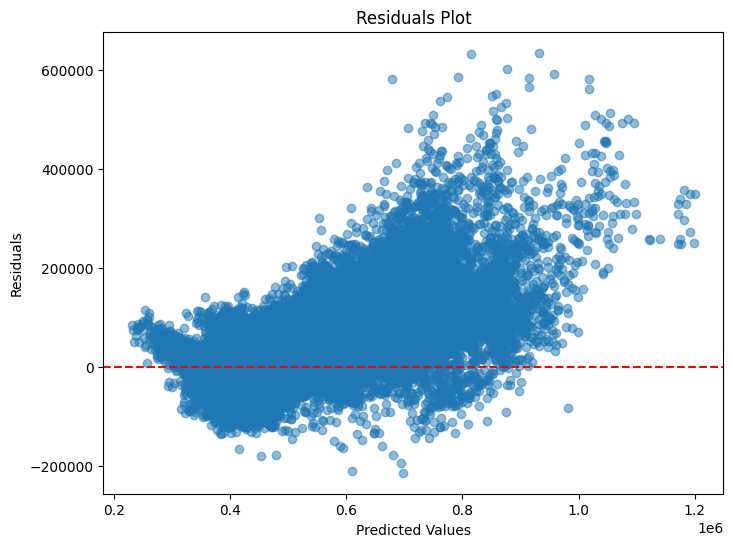

In [12]:
# Base linear regression (baseline)

pipeline_base = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_base.fit(X_train, y_train)
y_pred_base = pipeline_base.predict(X_test)
evaluate_model(pipeline_base, X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 9.4797
Mean CV R²: 0.3671

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 98224.45
Mean Absolute Error (MAE):      71331.99
R² Score:                       0.7309
Cross-validated R² scores: [0.56769337 0.16160152 0.33962088 0.51982404 0.01258252 0.7052428
 0.51013118 0.71240458 0.48867442 0.80531897]
Mean CV R²: 0.4823094282230526


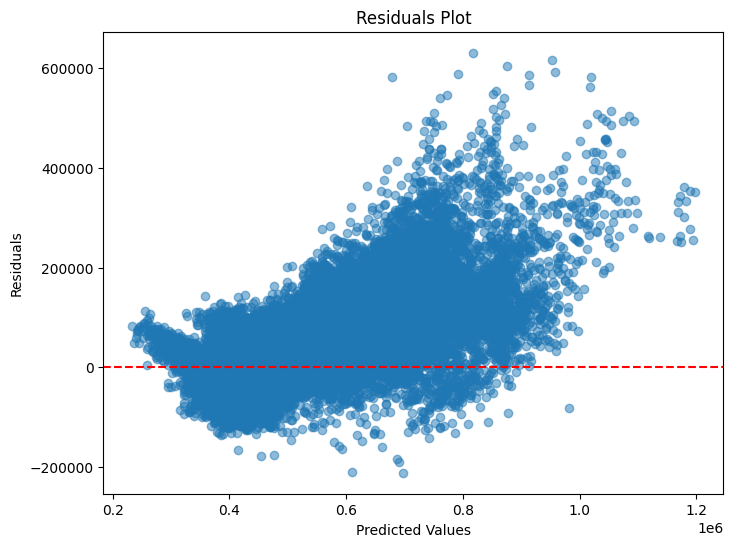

In [ ]:
memory = Memory(location=temp_dir, verbose=0)

pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',    Ridge())],
    memory=memory,
)

param_dist = {
    'regressor__alpha': loguniform(1e-4, 10)
}

tscv = TimeSeriesSplit(n_splits=5)

rand_search_ridge = RandomizedSearchCV(
    pipeline_ridge,
    param_distributions=param_dist,
    n_iter=100,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    random_state=123,
    verbose=2)

rand_search_ridge.fit(X_train, y_train)

best_alpha = rand_search_ridge.best_params_['regressor__alpha']
best_cv_r2 = rand_search_ridge.best_score_
print(f"Best alpha: {best_alpha:.4f}")
print(f"Mean CV R²: {best_cv_r2:.4f}")


best_ridge = rand_search_ridge.best_estimator_
evaluate_model(best_ridge, X_test, y_test)


## Target Evaluation Metrics (Linear Regression - Ridge)
- R2-score > 0.8
- RMSE < 10% of average resale price (2024 test period)
- MAE < 10% of average resale price (2024 test period)

In [20]:
y_pred = best_ridge.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

avg_price_2024 = y_test.mean()
mae_pct  = mae  / avg_price_2024
rmse_pct = rmse / avg_price_2024

print(f"\nAverage 2024 resale price : {avg_price_2024:,.0f} SGD")
print(f"MAE  : {mae:,.0f} SGD  ({mae_pct :.2%} of avg)")
print(f"RMSE : {rmse:,.0f} SGD  ({rmse_pct:.2%} of avg)")
print(f"R²   : {r2:.4f}\n")


Average 2024 resale price : 615,024 SGD
MAE  : 71,332 SGD  (11.60% of avg)
RMSE : 98,224 SGD  (15.97% of avg)
R²   : 0.7309



Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\ryanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1546568094004839.8, tolerance: 2565020797526.069
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha: 0.3957
Mean CV R²: -0.0487

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 101514.39
Mean Absolute Error (MAE):      73050.55
R² Score:                       0.7126
Cross-validated R² scores: [0.56521899 0.1736395  0.50953257 0.5224998  0.02611019 0.69659348
 0.48895047 0.69790392 0.48982367 0.79073912]
Mean CV R²: 0.4961011731091163


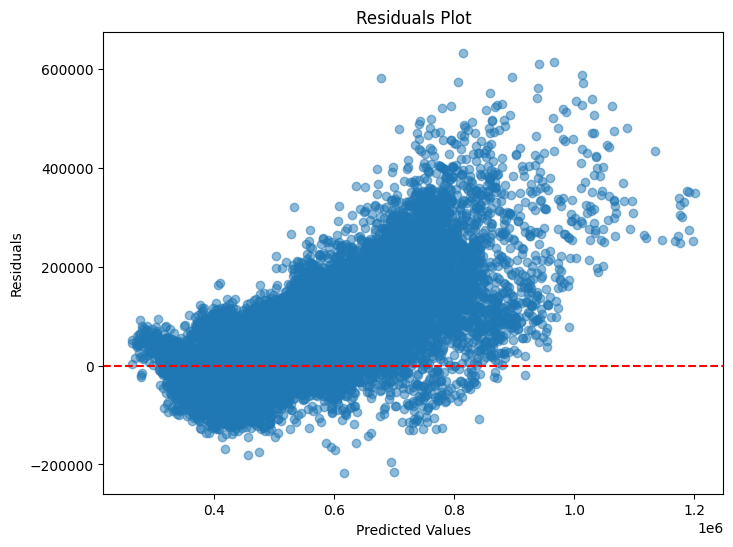

In [5]:
memory = Memory(location=temp_dir, verbose=0)

pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',    Lasso(max_iter=100, tol=1e-4))],
    memory=memory,
)

param_dist = {
    'regressor__alpha': loguniform(1e-4, 10)
}

tscv = TimeSeriesSplit(n_splits=3)

rand_search_lasso = RandomizedSearchCV(
    pipeline_lasso,
    param_distributions=param_dist,
    n_iter=5,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    random_state=123,
    verbose=2)

rand_search_lasso.fit(X_train, y_train)

best_alpha = rand_search_lasso.best_params_['regressor__alpha']
best_cv_r2 = rand_search_lasso.best_score_
print(f"Best alpha: {best_alpha:.4f}")
print(f"Mean CV R²: {best_cv_r2:.4f}")


best_lasso = rand_search_lasso.best_estimator_
evaluate_model(best_lasso, X_test, y_test)


## Target Evaluation Metrics (Linear Regression - Lasso)
- R2-score > 0.8
- RMSE < 10% of average resale price (2024 test period)
- MAE < 10% of average resale price (2024 test period)

In [25]:
y_pred = best_lasso.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

avg_price_2024 = y_test.mean()
mae_pct  = mae  / avg_price_2024
rmse_pct = rmse / avg_price_2024

print(f"\nAverage 2024 resale price : {avg_price_2024:,.0f} SGD")
print(f"MAE  : {mae:,.0f} SGD  ({mae_pct :.2%} of avg)")
print(f"RMSE : {rmse:,.0f} SGD  ({rmse_pct:.2%} of avg)")
print(f"R²   : {r2:.4f}\n")


Average 2024 resale price : 615,024 SGD
MAE  : 73,051 SGD  (11.88% of avg)
RMSE : 101,514 SGD  (16.51% of avg)
R²   : 0.7126



## Trying out XGBoost


Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 61922.58
Mean Absolute Error (MAE):      48720.83
R² Score:                       0.8931
Cross-validated R² scores: [0.30121755 0.6040363  0.94237627 0.9280827  0.82998996 0.49922503
 0.44293381 0.88041413 0.92269981 0.62553217]
Mean CV R²: 0.6976507722211015


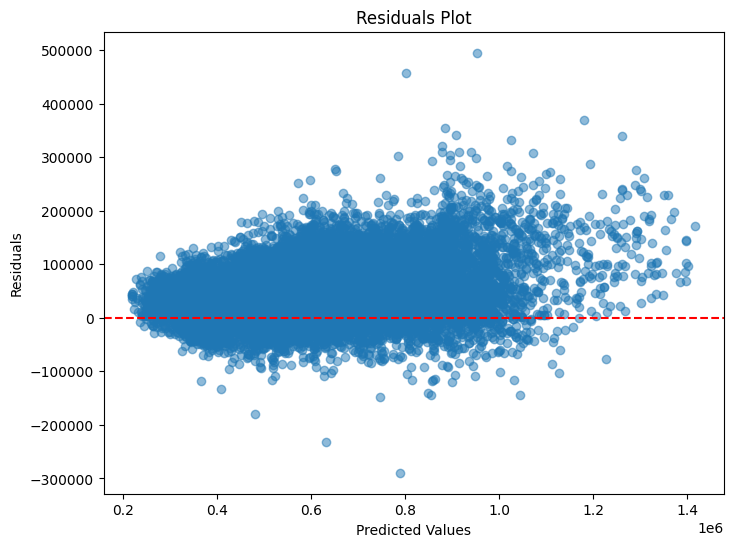

In [15]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=123,
        n_jobs=-1,
        objective='reg:squarederror',
        tree_method='hist'
    ))
])

pipeline_xgb.fit(X_train, y_train)

y_pred_xgb = pipeline_xgb.predict(X_test)
evaluate_model(pipeline_xgb, X_test, y_test)